# Biased Random Walks in Node2Vec

Node2Vec is an architecture based on DeepWalk, focusing on improving the quality of embeddings by modifying the way random walks are generated. This chapter discusses these modifications and how to find the best parameters for a given graph. It includes implementing Node2Vec and comparing it to DeepWalk using Zachary’s Karate Club dataset. Additionally, it covers building a movie recommender system (RecSys) powered by Node2Vec.

By the end of this chapter, you'll learn to implement Node2Vec on any graph dataset, select good parameters, and understand why it generally outperforms DeepWalk. You'll also see how to apply it to build creative applications.

Topics covered include:

- Introducing Node2Vec
- Implementing Node2Vec
- Building a movie RecSys

# Node2Vec

Node2Vec is a powerful algorithm for learning continuous feature representations of nodes in a graph. It extends the idea of random walks to create flexible and efficient node embeddings by simulating both Depth-First Search (DFS) and Breadth-First Search (BFS) strategies through the introduction of two parameters: the return parameter $ p $ and the in-out parameter $ q $.

## Transition Probabilities

Let’s take the following figure as an example. In this context, we denote the current node as $ j $, the previous node as $ i $, and the future node as $ k $. 

![](img/Node2Vec-example.png)

We define $ \pi_{jk} $ as the unnormalized transition probability from node $ j $ to node $ k $. This probability can be decomposed as follows:

$$
\pi_{jk} = \alpha(i, k) \cdot w_{jk}
$$

Where:
- $ \alpha(i, k) $ represents the search bias between nodes $ i $ and $ k $.
- $ w_{jk} $ is the weight of the edge from node $ j $ to node $ k $.

## Search Bias

In the original DeepWalk algorithm, the search bias $ \alpha(a, b) $ is set to 1 for any pair of nodes, meaning that all transitions are treated equally. However, in Node2Vec, the value of $ \alpha(a, b) $ is defined based on the distance $ d(a, b) $ between the nodes and the parameters $ p $ and $ q $. The role of these parameters is to control the exploration behavior of the random walk, approximating DFS and BFS as follows:

$$
\alpha(a, b) =
\begin{cases}
\frac{1}{p}, & \text{if } d(a, b) = 0 \\
1, & \text{if } d(a, b) = 1 \\
\frac{1}{q}, & \text{if } d(a, b) = 2
\end{cases}
$$

## Interpretation of Probabilities

Let’s decrypt these probabilities:

- **Return Probability**: When the walk starts from node $ j $ and arrives at node $ k $, the probability of returning to the previous node $ i $ is controlled by the parameter $ p $. A higher value of $ p $ encourages the random walk to explore new nodes rather than returning to the previous one, thus mimicking a DFS-like behavior.

- **Immediate Neighbors**: The unnormalized probability of moving to node $ k_1 $ when it is an immediate neighbor of $ i $ (i.e., $ d(i, k_1) = 1 $) is set to 1. This means that the random walk will always consider immediate neighbors as potential next steps.

- **Exploration of Distant Nodes**: The probability of transitioning to a node $ k_2 $ that is two hops away (i.e., $ d(i, k_2) = 2 $) is controlled by the parameter $ q $. A higher value of $ q $ will make the random walk focus more on nodes that are close to the previous node, resulting in a BFS-like exploration.

Node2Vec effectively balances exploration and exploitation in the random walk process by adjusting the transition probabilities based on the specified parameters $ p $ and $ q $. This flexibility allows Node2Vec to capture different structural properties of the graph, leading to meaningful node embeddings that can be used for various downstream tasks such as node classification, clustering, and link prediction.

In [ ]:
!pip install -q node2vec==0.4.6
!pip install -qI gensim==4.3.0

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\programs\\anaconda3\\envs\\pth\\Lib\\site-packages\\wrapt\\_wrappers.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



c:\programs\anaconda3\envs\pth\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


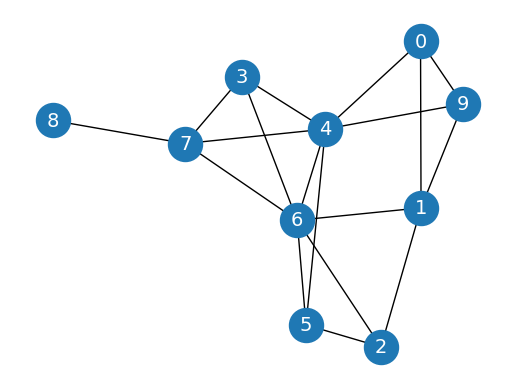

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Create graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [4]:
import random
random.seed(0)
import numpy as np
np.random.seed(0)

def next_node(previous, current, p, q):
    alphas = []

    # Get the neighboring nodes
    neighbors = list(G.neighbors(current))
    
    # Calculate the appropriate alpha value for each neighbor
    for neighbor in neighbors:
        # Distance = 0: probability to return to the previous node
        if neighbor == previous:
            alpha = 1/p
        # Distance = 1: probability of visiting a local node
        elif G.has_edge(neighbor, previous):
            alpha = 1
        # Distance = 2: probability to explore an unknown node
        else:
            alpha = 1/q
        alphas.append(alpha)

    # Normalize the alpha values to create transition probabilities
    probs = [alpha / sum(alphas) for alpha in alphas]
    
    # Randomly select the new node based on the transition probabilities
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [5]:
def random_walk(start, length, p, q):
    walk = [start]
    
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    
    return walk

In [6]:
random_walk(0, 8, p=1, q=1)

[0, 4, 7, 6, 4, 5, 4, 5, 6]

In [7]:
random_walk(0, 8, p=1, q=10)

[0, 9, 1, 9, 1, 9, 1, 0, 1]

In [8]:
random_walk(0, 8, p=10, q=1)

[0, 1, 9, 4, 7, 8, 7, 4, 6]

## Using classic classification methods on created node embeddings, such as random forest

For an introduction to Random Forest, see the [Data Minig Course at FUM](https://fum-cs.github.io/cs-bsc-dm/)

In [ ]:
wv_model = Word2Vec.load('word2vec_model.model')
# import pickle
# with open('word2vec_model.pkl', 'rb') as f: 
#     wv_model = pickle.load(f)

In [ ]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
G = nx.karate_club_graph()

true_labels = np.zeros((len(G.nodes)), dtype='int')
for i, node in enumerate(G.nodes):
    label = G.nodes[node]['club']
    true_labels[i] = (1 if label == 'Officer' else 0)

# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 3, 2))

# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# Our previous word2vec model
X_wv = np.array([wv_model.wv[str(node)] for node in G.nodes])
X_train_wv = X_wv[train_mask]
X_test_wv =  X_wv[test_mask]

# Create and train Word2Vec for DeepWalk
node2vec = Word2Vec(walks,
                hs=1,   # Hierarchical softmax
                sg=1,   # Skip-gram
                vector_size=50,
                window=10,
                workers=2,
                min_count=1,
                seed=0)
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

X_nv = np.array([node2vec.wv[node] for node in G.nodes])
X_train_nv = X_nv[train_mask]
X_test_nv =  X_nv[test_mask]

y_train = true_labels[train_mask]
y_test = true_labels[test_mask]

## Comparing Word2Vec and Node2Vec

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_wv, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test_wv)
acc_wv = accuracy_score(y_test, y_pred)
print(f'Accuracy (w2v embeddings) = {acc_wv*100:.2f}%')

clf.fit(X_train_nv, y_train)
y_pred = clf.predict(X_test_nv)
acc_nv = accuracy_score(y_test, y_pred)

print(f'Accuracy (n2v embeddings) = {acc_nv*100:.2f}%')

Accuracy (w2v embeddings) = 90.91%
Accuracy (n2v embeddings) = 100.00%


# Building a movie Recommender System

## MovieLens 100K Dataset

The MovieLens 100K dataset contains 100,000 ratings from 943 users on 1,682 movies. Each user has rated at least 20 movies. The data was collected through the MovieLens website during the seven-month period from September 19th, 1997 through April 22nd, 1998. This dataset is used for research in collaborative filtering and recommendation systems.

The ratings table contains the following columns:
- `user_id`: The ID of the user who rated the movie.
- `movie_id`: The ID of the movie that was rated.
- `rating`: The rating given to the movie by the user.
- `unix_timestamp`: The timestamp of when the rating was given.

The `rating` column contains values that represent the ratings given by users to movies. The ratings are on a discrete scale from 1 to 5, where:

- **1**: Indicates the lowest rating.
- **5**: Indicates the highest rating.

In [29]:
import os
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

# Define the URL
url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'

# Define the path to the 'var' directory
var_directory = 'var'

# Check if the 'var' directory exists, and create it if it does not
if not os.path.exists(var_directory):
    os.makedirs(var_directory)

# Download and extract the data
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall(var_directory)

print(f'Data has been downloaded and extracted to the {var_directory} directory.')


Data has been downloaded and extracted to the var directory.


In [48]:
import pandas as pd

ratings = pd.read_csv('var/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'])
ratings.shape

(100000, 4)

In [49]:
# Get the number of unique users 
num_unique_users = ratings['user_id'].nunique() 
print(f'The number of unique users is: {num_unique_users}')

The number of unique users is: 943


In [50]:
ratings.head()

user_id  movie_id  rating  unix_timestamp
0      196       242       3       881250949
1      186       302       3       891717742
2       22       377       1       878887116
3      244        51       2       880606923
4      166       346       1       886397596

In [51]:
movies = pd.read_csv('var/ml-100k/u.item', sep='|', usecols=range(2), names=['movie_id', 'title'], encoding='latin-1')
movies.shape

(1682, 2)

In [52]:
movies.head()

movie_id              title
0         1   Toy Story (1995)
1         2   GoldenEye (1995)
2         3  Four Rooms (1995)
3         4  Get Shorty (1995)
4         5     Copycat (1995)

In [54]:
# Only consider ratings with the highest score
ratings = ratings[ratings.rating >= 4]
num_unique_users = ratings['user_id'].nunique() 
print(f'The number of unique users is: {num_unique_users}')
print(ratings.shape)
ratings.head()

The number of unique users is: 942
(55375, 4)


user_id  movie_id  rating  unix_timestamp
5       298       474       4       884182806
7       253       465       5       891628467
11      286      1014       5       879781125
12      200       222       5       876042340
16      122       387       5       879270459

In [56]:
# Get the rows where user_id is 298 
user_298_ratings = ratings.loc[ratings['user_id'] == 298] 
print(user_298_ratings)

       user_id  movie_id  rating  unix_timestamp
5          298       474       4       884182806
122        298       317       4       884182806
614        298       181       4       884125629
1278       298       625       4       884183406
1859       298       252       4       884183833
...        ...       ...     ...             ...
74013      298         9       4       884126202
74659      298       357       5       884181969
74734      298       187       5       884183063
96001      298       282       4       884125629
98869      298       482       5       884182657

[91 rows x 4 columns]


# Building Movie Pair Frequencies

## Description
The following code snippet constructs a dictionary named `pairs` that stores the frequency of co-occurrences for each pair of movies rated by the same user. By iterating through the entire list of users and counting every instance where two movies are rated together, we can later use this information to create edges in a graph. This graph will represent the relationships between movies based on user ratings, allowing us to analyze movie similarities and user preferences.

In [57]:
from collections import defaultdict

pairs = defaultdict(int)

# Loop through the entire list of users
for group in ratings.groupby("user_id"):
    # List of IDs of movies rated by the current user
    user_movies = list(group[1]["movie_id"])

    # Count every time two movies are seen together
    for i in range(len(user_movies)):
        for j in range(i+1, len(user_movies)):
            pairs[(user_movies[i], user_movies[j])] += 1

The pairs object now stores the number of times two movies have been liked by the same
user. We can use this information to build the edges of our graph as follows.

In [58]:
# Create a networkx graph
G = nx.Graph()

# Try to create an edge between movies that are liked together
for pair in pairs:
    movie1, movie2 = pair
    score = pairs[pair]

    # The edge is only created when the score is high enough
    if score >= 20:
        G.add_edge(movie1, movie2, weight=score)

print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())

Total number of graph nodes: 410
Total number of graph edges: 14936


Here we use the node2vec library instead of creating random walks , ...

In [35]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, p=2, q=1, workers=1)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

c:\programs\anaconda3\envs\pth\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 1): 100%|██████████| 200/200 [00:40<00:00,  5.00it/s]


In [36]:
def recommend(movie):
    movie_id = str(movies[movies.title == movie].movie_id.values[0])
    for id in model.wv.most_similar(movie_id)[:5]:
        title = movies[movies.movie_id == int(id[0])].title.values[0]
        print(f'{title}: {id[1]:.2f}')

recommend('Star Wars (1977)')

Return of the Jedi (1983): 0.61
Raiders of the Lost Ark (1981): 0.55
Godfather, The (1972): 0.49
Indiana Jones and the Last Crusade (1989): 0.46
White Squall (1996): 0.44
